# Building an MLP Language Model
---

This is an extended version of Andrej Karpathy's notebook in addition to his [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on MLP language models.

Adapted by: 

Prof. Dr.-Ing. Antje Muntzinger, University of Applied Sciences Stuttgart

antje.muntzinger@hft-stuttgart.de

---

**NOTE:** You may answer in English or German.


# Table of Contents

[1. Text Generation with Multi-Layer-Perceptrons](#1.-Text-Generation-with-Multi-Layer-Perceptrons)

[2. Building the Dataset](#2.-Building-the-Dataset)

[3. Implementing the Neural Net](#3.-Implementing-the-Neural-Net)

[4. Training the MLP](#4.-Training-the-MLP)

[5. Training on Mini-Batches](#5.-Training-on-Mini-Batches)

[6. Tuning the Learning Rate](#6.-Tuning-the-Learning-Rate)

[7. Train-Valid-Test-Split](#7.-Train-Valid-Test-Split)

[8. Experiment: Larger Hidden Layer](#8.-Experiment:-Larger-Hidden-Layer)

[9. Visualization of the Embedding](#9.-Visualization-of-the-Embedding)

[10. Increasing the Embedding Dimension](#10.-Increasing-the-Embedding-Dimension)

[11. Final Evaluation and Sampling from the Model](#11.-Final-Evaluation-and-Sampling-from-the-Model)

[12. Challenge](#12.-Challenge)


## 1. Text Generation with Multi-Layer-Perceptrons

In the last notebook, we implemented a bigram language model in two versions: by counting the occurences of bigrams as well as by building a simple neural net with just a single layer. The problem with this approach is that if we are to take more context into account when predicting the next character in a sequence, things quickly blow up. For example, we had a 27x27 lookup table to predict the next token from the previous one. If we want to take the last 2 characters to predict the next, we already have a 27x27x27 lookup table, so the number of possible combinations grows exponentially with the length of the context. Therefore, we will explore a different approach here and implement a **Multi-Layer Perceptron (MLP)** following the 2003 paper
[A Neural Probabilistic Language Model](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbW9DTXY3aXpoa2doT1JXclNpUTZIS1h6V1RNd3xBQ3Jtc0tsdHZ6aUs3ck94TU5MVkNwSXpQd0VvLUdMRjVadmt1eGpLMXlCMGVTWWJqa1VobU13dXRxamNTa09aYk5hc2hoN0pEeHNMM2hSbFRBaVZBeVFUay1TRmFvRzBIaGhFb21QdHlIVzFzX09rd1NIWEVuSQ&q=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume3%2Fbengio03a%2Fbengio03a.pdf&v=TCH_1BHY58I) by Bengio et al. This was not the first paper applying an MLP to generate text, but it was very influential and is a nice write-up. In the paper, they used a word level language model with a vocabulary of 17 000 possible words. We will still use a character level language model, but follow the paper other than that. 

The idea of the paper is the following: To each word, a thirty dimensional feature vector is associated, so every word gets **embedded** into a thirty dimensional space. So we have 17 000 points or vectors in a 30 dimensional space (that's very crowded!) Now in the beginning these words are initialized randomly so they're spread out at random, but then we're going to tune these embeddings of the words using backpropagation. So during the training of this neural network, these vectors are going to move around and words that have  similar meanings or that are synonyms end up in a similar part of the space. Conversely, words with different meaning would go somewhere else in the space. Their modeling approach otherwise is identical to ours: They are using a multi-layer neural network to predict the next word given the previous words, and for training they are maximizing the log likelihood of the training data.

Why does this work? Suppose we want to complete the sentence 

    'A dog was running in a ...', 
    
which has never occured in the training data, so we are **out of distribution**.  But maybe the network has seen the sentence

    'The dog was running in a ...', 

and it has learned that 'a' and 'the' are frequently interchangeable, so it took the embeddings for 'a' and 'the' and put them nearby each other in the space. This is how the net can transfer knowledge through that embedding and generalize. Similarly, the network could know that cats and dogs are animals and they co-occur in lots of very similar contexts, and so even though you haven't seen this exact phrase, it can through the embedding space transfer knowledge and generalize to novel scenarios. Here is a nice visualization of embeddings (source: https://causewriter.ai/courses/ai-explainers/lessons/vector-embedding/):

<img src="img/embeddings.png" width="500">



Now let's take a closer look at the MLP:

<img src="img/MLP.jpg" width="600">

- *Input Layer:* Here, we are taking 3 previous words to predict the next word. The input is the index of the word, an integer between 0 and 16999 for 17 000 words. They use a lookup table C, a 17000x30 matrix, where every index is plucking out a row of this embedding matrix, so each index is converted to the 30 dimensional embedding vector for that word. The input layer consists of 30 neurons for three words making up 90 neurons in total. The matrix C is shared across all the words, so we're always indexing into the same matrix C over and over for each one of these words. 

- *Hidden Layer:* Then the data is processed to a hidden layer, where the size is a **hyperparameter** (a design choice up to the designer of the neural net), followed by a tanh nonlinearity. 

- *Output Layer:* Finally, the output layer consists of 17 000 neurons for all possible next words. So there are 17 000 logits followed by a softmax layer to calculate a probability distribution for the next word in the sequence. 

During training we have the label (=identity of the next word in a sequence), so we can pluck out the probability of that word and maximize the probability of that word with respect to the parameters of the neural net. The parameters that are optimized via backpropagation are the weights and biases of the output layer, the weights and biases of the hidden layer and the embedding lookup table C.

Now let's implement this network!

## 2. Building the Dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We introduce the **block size** (or **context length**) parameter telling us how many characters we use to predict the next, here 3. We store the **context** (=3 consecutive characters) in X and the labels (=the next character) in Y:

In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
    
        print(w)
        context = [0] * block_size # [0, 0, 0] (pad with zeros='.')
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # input
            Y.append(ix) # labels
            print(''.join(itos[i] for i in context), '--->', itos[ix]) # 'emma' contains 5 training examples
            context = context[1:] + [ix] # crop and append (rolling window of context) e.g. [0, 0, 5], then [0, 5, 13]..
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


X, Y = build_dataset(words[:5]) # let's just work on a small dataset of 5 names for now

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
...truncated...

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype # we generated 32 training examples out of the 5 first words, each has 3 characters

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## 3. Implementing the Neural Net

Now let's build the *embedding table C*. In the paper, they have 17 000 words and they embed them in a comparably small 30 dimensional space. In our case, we have only 27 possible characters, so let's embed them in a comparably small space - let's start with a two-dimensional space:

In [6]:
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)

We visualize the 2D embeddings of all characters (which are untrained yet, just randomly initialized). Remember that they start anywhere in embedding space and move around during training, clustering in some meaningful way.

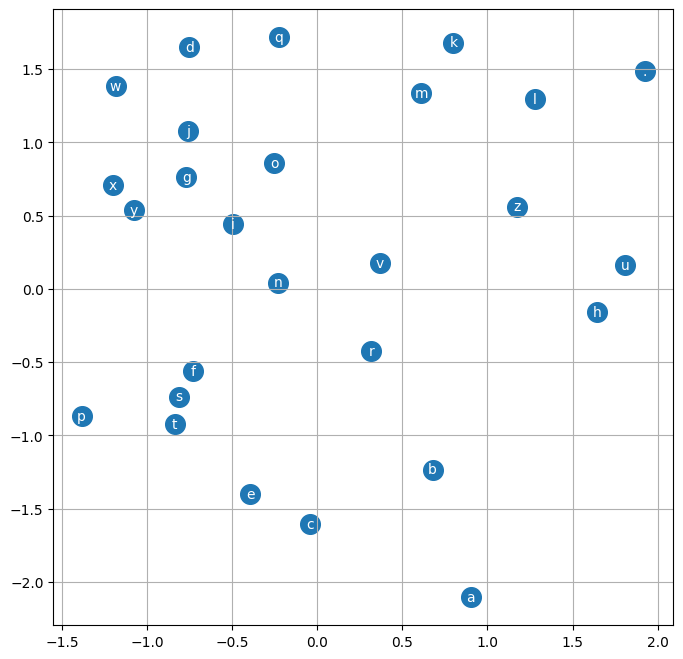

In [7]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

There are two methods to pluck out the 5th row:

Option 1 - Directly plucking the embeddings from C:

In [8]:
C[5]

tensor([-0.3925, -1.4036])

Option 2 - Calculating the one-hot encoding of 5 and multiplying it with the embedding matrix:

In [9]:
F.one_hot(torch.tensor([5]), num_classes=27)

In [10]:
F.one_hot(torch.tensor([5]), num_classes=27).float() @ C # note that we need to convert the one-hot to float from int to match the type of C

tensor([[-0.3925, -1.4036]])

Therefore, we can either think of the embedding as an integer indexing into a lookup table C, or as a first layer of the neural net with weight matrix C (without nonlinearity), where we encode integers into one-hot vectors and feed them in. Here, we are going to use the first interpretation with indexing because it is faster. But how can we simultaneously index all 32x3 integers stored in X? Luckily, we can also index with a list or tensor in PyTorch:

In [11]:
C[[4,4,5]], C[torch.tensor([4,4,5])] # indexing with a list or tensor of indices

(tensor([[-0.7521,  1.6487],
         [-0.7521,  1.6487],
         [-0.3925, -1.4036]]),
 tensor([[-0.7521,  1.6487],
         [-0.7521,  1.6487],
         [-0.3925, -1.4036]]))

In [12]:
X[13,2], C[X][13,2], C[1] # another example for indexing

(tensor(1), tensor([ 0.9007, -2.1055]), tensor([ 0.9007, -2.1055]))

In [13]:
emb = C[X] # we can even directly use the tensor X to index into C
emb.shape # shape of the embeddings - we need to flatten them for the hidden layer

torch.Size([32, 3, 2])

**TODO (optional):** Why is the shape of the embedding 32x3x2?

**ANSWER:** 
The shape of the embedding emb is 32x3x2 because:

- 32: This is the number of examples in the dataset X. Each example represents a context of characters.
- 3: This is the context length (block_size), which indicates how many characters are used to predict the next one. In this case, the block_size is 3.
- 2: This is the number of features in the embedding matrix C. Each row in C represents a character and has 2 features.

When we execute C[X], each character in the context is replaced by its corresponding embedding. Since X has the shape (32, 3) and C has the shape (27, 2), C[X] results in the shape (32, 3, 2).

Here is a visualization of our embedding of input '.em' (actually 3 embeddings, each token plucks out the corresponding row of C independently):

<img src="img/MLP1.jpg" width="400">


Now let's implement the *hidden layer* of size 100 (a design choice). We start by initializing weights and biases:

In [14]:
W1 = torch.randn((6, 100)) # 6 = block_size * emb_dim = 3 * 2, 100 = hidden size (design choice)
b1 = torch.randn(100) # bias for the hidden layer

We calculate the weighted sum (**logits**) and apply the **tanh() activation**: 

In [15]:
logits = emb.view(-1, 6) @ W1 + b1 # reshaping the embeddings to (batch_size, block_size * emb_dim) and applying the linear layer

In [16]:
h = torch.tanh(logits) # apply tanh activation

In [17]:
h

In [18]:
h.shape

torch.Size([32, 100])

Here is a visualization of our hidden layer after flattening the embedding:

<img src="img/MLP2.jpg" width="700">

And the *output layer*:

In [19]:
W2 = torch.randn((100, 27)) # 100 = hidden size, 27 = vocab size
b2 = torch.randn(27)
print(W2)
print(b2)

tensor([[ 1.8770,  0.9237, -1.0040,  ..., -0.3145,  1.0061, -0.5347],
        [-1.0067, -0.0308,  1.8133,  ..., -0.8896, -1.6704, -0.9865],
        [ 0.3107,  0.5558,  0.4097,  ...,  1.2207,  0.7545, -0.6213],
        ...,
        [-0.1550,  1.0090,  0.4623,  ..., -0.4764,  0.8481,  1.0267],
        [ 2.0631,  0.8216, -0.1671,  ..., -0.2536,  0.0621,  0.9305],
        [-0.6627, -0.5174, -0.0130,  ..., -1.1271, -0.4265,  1.2204]])
tensor([ 0.1987, -1.0425,  0.2437, -0.8766,  0.9437,  0.0426,  0.2838, -0.4403,
         0.3755,  1.8296, -0.8599, -0.2614, -1.3058,  0.0976,  0.4677, -0.0184,
         0.1505, -2.4974, -0.4194, -0.7672,  0.5859, -1.2380,  0.3298, -0.1125,
         0.8877,  0.2525,  0.0338])


**TODO:** 3a) Calculate the logits (weighted sum) with input `h`, weights `W2` and bias `b2`. Store the result in `logits`. What is the shape of the output and why? **(3 points)**

In [20]:
# YOUR CODE GOES HERE
logits = h @ W2 + b2 # ((32,100)x(100,27) + (27))
print("Logits:", logits)
print("Shape of logits:", logits.shape)


Logits: tensor([[ 5.8636e+00,  7.5580e-01,  1.9294e+00,  6.3613e+00, -1.0576e+01,
          6.1022e+00, -2.3862e+00, -5.3747e+00, -8.4565e+00, -1.5330e+01,
          1.6783e+01,  2.2608e+00, -5.2444e+00,  2.3100e+00,  6.5188e+00,
         -1.4921e+00,  2.6113e+00,  3.8025e+00, -1.6415e+01,  7.5550e-01,
         -7.8111e+00, -9.5759e+00, -4.6794e+00,  1.6634e+01,  9.5468e+00,
          1.0558e+01, -9.2662e+00],
        [ 5.7929e+00,  5.7800e+00, -4.6364e+00,  1.8596e+00, -1.0374e+00,
          8.9760e+00,  3.0109e+00, -8.8267e+00,  2.1796e-01, -1.4150e+01,
          6.7740e+00, -3.6404e+00, -5.3284e+00, -3.7103e+00, -1.2881e+01,
          7.7390e-01, -4.9831e-01, -6.3980e-01, -7.0465e+00,  8.9352e+00,
          7.5856e+00, -1.6123e+01,  8.4585e+00,  2.8439e+01,  1.9258e+01,
          1.5235e+00, -9.9501e+00],
        [ 8.5527e+00,  1.5973e+00,  2.8514e+00,  7.0990e+00, -9.6598e-01,
         -3.1645e+00,  8.2829e+00, -1.4740e+01, -3.9475e+00, -1.2960e+00,
          2.4873e+01, -1.3161e+0

**ANSWER:** 
Because in hidden layer we have 32 data and for each data we have 100D representation,and we have W with shape (100,27). When we multiply our new input layer with weights (32,100)x(100,27), the output layer would be in shape (32,27) and adding bias is a scalar operation which doesnt change the shape of the output layer.

**TODO:** 3b) Calculate the counts by exponentating the logits and store the result in `counts`, then normalize to get probabilities and store the result in `prob`. **(2 points)** 

**HINT:** Remember the bigram model!

In [21]:
# YOUR CODE GOES HERE
counts = torch.exp(logits)
prob = counts / counts.sum(dim=1, keepdims=True)
print(prob.shape)
print("Probabilities:", prob)

torch.Size([32, 27])
Probabilities: tensor([[9.7096e-06, 5.8736e-08, 1.8993e-07, 1.5972e-05, 7.0432e-13, 1.2325e-05,
         2.5371e-09, 1.2778e-10, 5.8623e-12, 6.0671e-15, 5.3636e-01, 2.6457e-07,
         1.4557e-10, 2.7791e-07, 1.8696e-05, 6.2038e-09, 3.7560e-07, 1.2361e-06,
         2.0489e-15, 5.8719e-08, 1.1177e-11, 1.9138e-12, 2.5612e-10, 4.6213e-01,
         3.8618e-04, 1.0615e-03, 2.6085e-12],
        [1.4615e-10, 1.4428e-10, 4.3193e-15, 2.8615e-12, 1.5792e-13, 3.5253e-09,
         9.0483e-12, 6.5398e-17, 5.5414e-13, 3.1904e-19, 3.8982e-10, 1.1694e-14,
         2.1622e-15, 1.0904e-14, 1.1350e-18, 9.6619e-13, 2.7074e-13, 2.3502e-13,
         3.8789e-16, 3.3842e-09, 8.7770e-10, 4.4362e-20, 2.1012e-09, 9.9990e-01,
         1.0298e-04, 2.0446e-12, 2.1267e-17],
        [8.1659e-08, 7.7860e-11, 2.7288e-10, 1.9084e-08, 5.9990e-12, 6.6567e-13,
         6.2348e-08, 6.2528e-18, 3.0423e-13, 4.3129e-12, 1.0000e+00, 4.2269e-12,
         1.2065e-13, 2.9175e-11, 2.6077e-12, 1.8268e-10, 1.935

This is a visualization of our complete MLP:

<img src="img/MLP3.jpg" width="800">

Finally we calculate the cross entropy loss:

In [22]:
loss = -prob[torch.arange(len(Y)), Y].log().mean() # cross-entropy loss
loss

tensor(19.1771)

## 4. Training the MLP

Let's summarize the code so far and train the network! We summarize all trainable parameters in a list called `parameters`:

In [23]:
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list for counting the number of parameters

In [24]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [25]:
for p in parameters:
    p.requires_grad = True 

**TODO:** 4a) Research why we need to set `requires_grad = True`, e.g. in the PyTorch documentation! **(1 point)** 

**ANSWER:** 
When `requires_grad = True`, PyTorch tracks all operations on this tensor to calculate the gradients during the backpropagation: These gradients are then used to update the parameters in `p` in the direction of the gradient descent.

**TODO:** 4b) In the code block below, try to understand what each line of code does, and comment each line! **(3 points)**

In [26]:
# YOUR COMMENTS GO HERE

niter = 1000 #number of iterations for training

for i in range(niter): 

    # forward pass
    emb = C[X] # for each iteration create an embedding layer for all blocks
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # flatten it, calculate weighted sum and by using tanh activation function,calculate the values for the hidden layer
    logits = h @ W2 + b2 # by using the hidden layer as an input, now  calculate a weighted sum for the output layer
    loss = F.cross_entropy(logits, Y) # calculate the cross entropy loss between logits and true labels y
    
    # backward pass
    for p in parameters: 
        p.grad = None # clears the gradients of the model's parameters, removes any gradient values left over from the previous training step. 
    loss.backward()  # computes the gradient of the loss function with respect to each parameter through backpropagation
    
    # update
    for p in parameters: 
        p.data += -0.1 * p.grad # updates each parameter by subtracting calculated gradients values with 0.1 learning rate

    print(loss.item()) # prints the loss tensor values

17.775842666625977
14.432573318481445
12.249408721923828
10.555495262145996
9.166698455810547
8.059216499328613
7.099236965179443
6.237092018127441
5.497320175170898
4.880398750305176
4.3454132080078125
3.8748481273651123
3.4561686515808105
3.079040050506592
2.730928897857666
2.4046106338500977
2.101841688156128
1.8323787450790405
1.6064157485961914
1.4234545230865479
...truncated...

**TODO:** 4c) Can you interpret the loss - why is it so small? **(2 points)**

**HINT:** Is a small training loss always a good sign, or should we consider other factors as well?

**ANSWER:**   A small loss indicates a great learning rate and a good number of itterations and is usually a good sign but It can also be a sign for overfitting.

**TODO:** 4d) Can we reach a loss of exactly 0 when continuing optimization? Why or why not? **(2 points)**

**ANSWER:** We can't reach a loss of exactly 0 because language modeling is probabilistic, the model has limited capacity, cross-entropy loss never becomes 0 due to probabilities, and optimization or data noise prevents perfect predictions.

Summing all steps in a visualization, including cross entropy loss calculation:


<img src="img/MLP4.jpg" width="900">

---

## 5. Training on Mini-Batches

**TODO:** 5a) Read in the whole dataset for training instead of the first 5 words and store the inputs and labels in X and Y again! How many training examples do we have now roughly? **(2 points)** 

**HINT:** Use the `build_dataset()` function defined above!

In [27]:
# YOUR CODE GOES HERE
X,Y = build_dataset(words)
print(X.shape , Y.shape)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
...truncated...

**ANSWER:** In the actual dataset names.txt, the total number of contexts generated is 228146, which means the combined length of all names in the dataset results in this number of contexts when using a block_size of 3.

In practice, it is too computationally expensive to forward and backward pass the whole training set at once. Instead, we use **mini-batches** of e.g. 32 randomly chosen examples processed in parallel. The quality of the gradient might be a little lower because we are not using all data, the direction of the gradient is not the exact actual direction, but it is good enough and we can simply calculate more steps to compensate this.   

We can use `randint` for random sampling of the batch examples. Like this, we sample 32 random row indices of X (wicht is now of shape 228146 x 3):

In [28]:
torch.randint(0, X.shape[0], (32,)) # example of sampling from a uniform distribution (low, high, shape)

This is the training loop with random mini-batches of size 32:

In [29]:
niter = 1000 # number of iterations

for i in range(niter):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 10)? 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200) ? 32,100
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # instead of the manual computation above (more efficient and numerically stable)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None # reset the gradients
    loss.backward() # compute the gradients
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

10.387406349182129
13.053986549377441
9.804208755493164
11.398539543151855
8.367438316345215
7.649349212646484
10.547525405883789
9.974981307983398
9.609989166259766
9.53652286529541
8.27939224243164
9.283623695373535
10.240114212036133
7.509037494659424
7.361513614654541
7.401601314544678
6.334048748016357
8.907212257385254
7.320008277893066
5.5575785636901855
...truncated...

## 6. Tuning the Learning Rate

The code blocks below summarize the code so far. For repeated execution, we write a function `trainloop()` that can be called with different numbers of iterations, learning rates etc:

In [30]:
# reset the parameters
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list for counting the number of parameters

for p in parameters:
    p.requires_grad = True # we want to learn the parameters
    

In [31]:
# define the training loop as a function
def trainloop(niter, X, Y, parameters, lrs, output=True, emb_dim=2, context_length=3):  

    # keep track of the losses and steps
    lossi = []  
    stepi = []
    
    for i in range(niter):
        
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (32,))
        
        # forward pass
        emb = C[X[ix]] # (32, 3, 10)? 2
        h = torch.tanh(emb.view(-1, emb_dim*context_length) @ W1 + b1) # (32, 200)
        logits = h @ W2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y[ix]) # instead of the manual computation above (more efficient and numerically stable)
        if output:
            print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad = None # reset the gradients
        loss.backward() # compute the gradients
        
        # update
        lr = lrs[i]
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        stepi.append(i)
        lossi.append(loss.log10().item())

    return parameters, stepi, lossi

In [32]:
# define the hyperparameters and run the training loop
niter = 1000 # number of iterations

lrs = torch.full((niter,), 0.1) # learning rates = tensor of constant values (0.1) for all iterations

parameters, stepi, lossi = trainloop(niter, X, Y, parameters, lrs) # run the training loop

15.427766799926758
13.775408744812012
11.398277282714844
11.550265312194824
12.754717826843262
13.796286582946777
10.55596923828125
11.49148941040039
10.741220474243164
12.743672370910645
11.506134033203125
7.532491683959961
10.222014427185059
11.218327522277832
10.42318344116211
9.22864818572998
8.981110572814941
8.208964347839355
9.016417503356934
8.569552421569824
...truncated...

**TODO:** 6a) Experiment with different learning rates. Don't forget to reset the parameters first! Which learning rate seems to work best? Which learning rates are too high or too low? **(3 points)**

In [33]:
# YOUR EXPERIMENTS HERE
# reset the parameters
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list for counting the number of parameters

for p in parameters:
    p.requires_grad = True # we want to learn the parameters

lrs = torch.full((niter,), 1)
parameters, stepi, lossi = trainloop(niter, X, Y, parameters, lrs)

16.736488342285156
13.620193481445312
13.274978637695312
14.744308471679688
15.702707290649414
12.305155754089355
10.294249534606934
11.231122016906738
8.613259315490723
8.862308502197266
10.051679611206055
6.934103488922119
10.614493370056152
9.752668380737305
11.591850280761719
6.959422588348389
9.2140531539917
8.47493839263916
10.749691009521484
7.59122896194458
...truncated...

In [34]:
# YOUR EXPERIMENTS HERE
# reset the parameters
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list for counting the number of parameters

for p in parameters:
    p.requires_grad = True # we want to learn the parameters

lrs = torch.full((niter,), 0.001)
parameters, stepi, lossi = trainloop(niter, X, Y, parameters, lrs)


17.380922317504883
18.230884552001953
15.098654747009277
17.996431350708008
12.570591926574707
15.815083503723145
16.796924591064453
18.71610450744629
16.273319244384766
17.3035831451416
16.730833053588867
16.222904205322266
17.31536293029785
15.629059791564941
14.934259414672852
15.407294273376465
14.929421424865723
15.743674278259277
16.829980850219727
17.698183059692383
...truncated...

In [35]:
# YOUR EXPERIMENTS HERE
# reset the parameters
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list for counting the number of parameters

for p in parameters:
    p.requires_grad = True # we want to learn the parameters

lrs = torch.full((niter,), 0.09)
parameters, stepi, lossi = trainloop(niter, X, Y, parameters, lrs)

17.88709259033203
17.247684478759766
15.639723777770996
15.34082317352295
13.700202941894531
12.42990493774414
10.037654876708984
13.683521270751953
13.314544677734375
12.758869171142578
10.763583183288574
8.411131858825684
8.912544250488281
8.995594024658203
10.168986320495605
10.51961898803711
7.769402980804443
7.525182247161865
9.064567565917969
7.437386989593506
...truncated...

**ANSWER:** 1 or higher learning rates are too large,model probably missed the local minima. 0.01 or lower rates are too small, model probably couldn't reach the local minima in niter step. Learning rates around 0.1 ( ie. 0.09) look like a better option when we check the loss.

We can make the search more systematic using **grid search** techniques:

In [36]:
# systematically test different learning rates (logarithmically spaced between 1e-3 and 1)
lre = torch.linspace(-3, 0, 1000) # lre = learning rate exponent = log10(learning rate)
lrs = 10**lre

In [37]:
# reset the parameters
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list

for p in parameters:
    p.requires_grad = True # we want to learn the parameters
    

parameters, stepi, lossi = trainloop(niter, X, Y, parameters, lrs) # run the training loop

15.917977333068848
15.994047164916992
15.209294319152832
16.573200225830078
17.601064682006836
17.05906867980957
17.44671058654785
16.642803192138672
16.11324691772461
14.065044403076172
15.380486488342285
16.32643699645996
15.272849082946777
16.22369384765625
16.77284812927246
16.531007766723633
18.68752670288086
14.285012245178223
17.1718692779541
17.375411987304688
...truncated...

**TODO:** 6b) Plot the loss over the different learning rate exponents. Which learning rate should we use? **(2 points)**

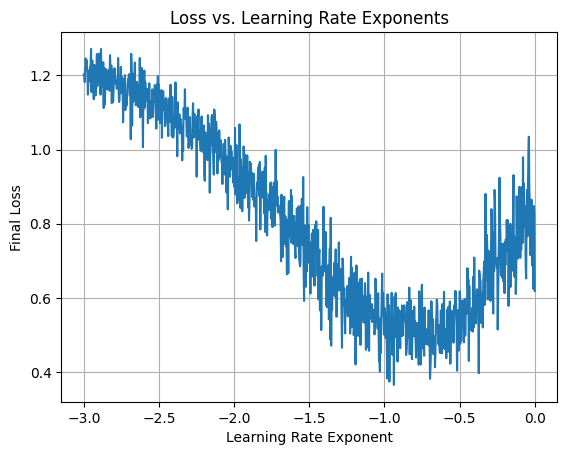

In [38]:
# YOUR CODE GOES HERE
plt.plot(lre, lossi)
plt.xlabel('Learning Rate Exponent')
plt.ylabel('Final Loss')
plt.title('Loss vs. Learning Rate Exponents')
plt.grid(True)
plt.show()

**ANSWER:** -0.75 learning rate exponent looks the best option. Which means: 10**(-0.75)=0.177 learning rate

Now that we have found a good learning rate, let's only do one step of **learning rate decay** and run for a very long time. This is how you would roughly proceed in production as well: Find a good learning rate via grid search, train with it until the loss reaches a plateau, then decrease the learning rate some more and see if the loss goes down again. 

In [39]:
# reset the parameters
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list for counting the number of parameters

for p in parameters:
    p.requires_grad = True # we want to learn the parameters

In [40]:
niter = 100000 # number of iterations

lrs = torch.full((niter,), 0.1) # learning rates = tensor of constant values (0.1) for the first 50 000 iterations
lrs[50000:] = 0.01 # learning rates = tensor of constant values (0.01) for the remaining 50 000 iterations

parameters, stepi, lossi = trainloop(niter, X, Y, parameters, lrs, output=False) # run the training loop

In [41]:
# evaluate loss
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2851, grad_fn=<NllLossBackward0>)

We see that the loss is at 2.29, which is already better than the bigram model from the last notebook, which was 2.45! 

...except that this is not exactly true: The loss on the training data could become very small only due to overfitting. The model could only memorize the training data and perform very good on these, but poorly once you test it with new data. Therefore, the data is usually split in 3 parts: The **training data** (e.g. 80%) is used for parameter optimization like we did above using gradient descent. The **validation data** or **dev data** (e.g. 10%) is used for tuning hyperparameters (e.g. size of the hidden layer, size of the embedding, learning rate...) and the **test data set** (e.g. 10%) is kept aside to measure the final performance and generalization capabilities of the model. The test set should only be used once because each time you evaluate on the test set and learn something from it, you basically train on the test set, so you also risk overfitting to your test set and will not be able to measure generalization capabilities anymore. So let's implement this:

## 7. Train-Valid-Test-Split

**TODO:** 7a) Split the data in 80% training data stored in `Xtr`, `Ytr`, 10% dev data stored in `Xdev`, `Ydev` and 10% test data stored in `Xte`, `Yte`. Don't forget to randomly shuffle the words first. **(3 points)**

**HINT:** You can use `random.shuffle` to shuffle the words. Then, create the data splits and call `build_dataset()` with the created subsets.

In [42]:
# YOUR CODE GOES HERE
# randomly shuffle the words
random.shuffle(words)  # Shuffle the words randomly

# Split into 80% training, 10% development, and 10% test
train_words = words[:int(0.8 * len(words))]
dev_words = words[int(0.8 * len(words)):int(0.9 * len(words))]
test_words = words[int(0.9 * len(words)):]

# Build datasets for each split
Xtr, Ytr = build_dataset(train_words)
Xdev, Ydev = build_dataset(dev_words)
Xte, Yte = build_dataset(test_words)

# Print the sizes of the splits
print(f"Training set size: {Xtr.shape[0]}")
print(f"Development set size: {Xdev.shape[0]}")
print(f"Test set size: {Xte.shape[0]}")

ayomide
... ---> a
..a ---> y
.ay ---> o
ayo ---> m
yom ---> i
omi ---> d
mid ---> e
ide ---> .
odyssey
... ---> o
..o ---> d
.od ---> y
ody ---> s
dys ---> s
yss ---> e
sse ---> y
sey ---> .
flavia
... ---> f
...truncated...

**TODO**: 7b) Train the model on the training data only, then evaluate on the train data and the dev data for comparison. Don't forget to reset the parameters first! **(3 points)**

In [43]:
# YOUR CODE GOES HERE
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster all parameters in one list for counting the number of parameters

for p in parameters:
    p.requires_grad = True # we want to learn the parameters

niter = 100000 # number of iterations

lrs = torch.full((niter,), 0.1) # learning rates = tensor of constant values (0.1) for the first 50 000 iterations
lrs[50000:] = 0.01 # learning rates = tensor of constant values (0.01) for the remaining 50 000 iterations

parameters, stepi, lossi = trainloop(niter, Xtr, Ytr, parameters, lrs, output=False) # run the training loop


# evaluate loss for training data
emb_tr = C[Xtr] # (32, 3, 2)
h_tr = torch.tanh(emb_tr.view(-1, 6) @ W1 + b1) # (32, 100)
logits_tr = h_tr @ W2 + b2 # (32, 27)
loss_tr = F.cross_entropy(logits_tr, Ytr)

# evaluate loss for development data
emb_dev = C[Xdev] # (32, 3, 2)
h_dev = torch.tanh(emb_dev.view(-1, 6) @ W1 + b1) # (32, 100)
logits_dev = h_dev @ W2 + b2 # (32, 27)
loss_dev = F.cross_entropy(logits_dev, Ydev)

print(f"Training Loss: {loss_tr.item():.4f}")
print(f"Development Loss: {loss_dev.item():.4f}")

Training Loss: 2.2825
Development Loss: 2.2956


**TODO:** 7c) How do you interpret the train versus dev loss? **(1 point)**

**ANSWER:**  Dev loss is higher than train loss which is understandable because model have seen the train data before, but not the validation data. Additionally, the small gap between training loss and dev loss indicates no overfitting.
 

---

## 8. Experiment: Larger Hidden Layer

**TODO:** 8a) Experiment with a hidden layer of size 300 and train for a long time. Plot the loss over the steps (not the learning rate this time!). We are expecting to further decrease the training loss because we have a more powerful network now. Can we achieve this? **(3 points)**

In [44]:
# YOUR CODE GOES HERE
hidden_size = 300
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True # we want to learn the parameters
    
# learning_rate = 0.1
# lrs = torch.full((niter,), learning_rate)

parameters, stepi, lossi = trainloop(niter, X, Y, parameters, lrs) # run the training loop

34.0537223815918
24.141265869140625
24.394527435302734
21.658418655395508
15.647573471069336
22.252897262573242
22.52055549621582
20.22591781616211
16.766881942749023
18.237930297851562
15.998733520507812
9.190446853637695
23.14169692993164
16.185285568237305
16.29927635192871
13.21138858795166
11.635815620422363
14.37590503692627
11.671236038208008
10.453657150268555
...truncated...

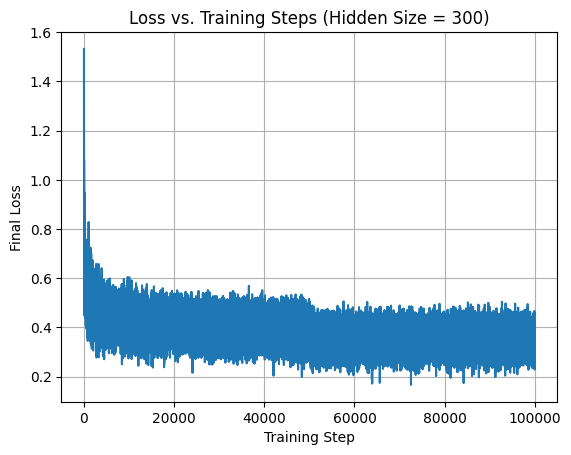

In [45]:
# YOUR CODE GOES HERE
plt.plot(stepi, lossi, label="Training Loss")
plt.xlabel('Training Step')
plt.ylabel('Final Loss')
plt.title("Loss vs. Training Steps (Hidden Size = 300)")
plt.grid(True)
plt.show()

**ANSWER:** We can not achieve this because more complex model might lead to overfit. As we can see loss didnt decrease under 0.2, it is about 2.28 which is almost same as previous model's.

**TODO:** 8b) Why is the loss so noisy, not decreasing monotonically? **(1 point)**

**ANSWER:** Because we are training with-mini Batches. Loss depends on the data in related batches. Unlike the classical method, it does not find the steepest slope, but finds a slope based on the items in the batch.

## 9. Visualization of the Embedding

The training loss is not really decreasing with increased hidden layer. It could be that the bottleneck of the network right now are the embeddings that are twodimensional. Intuitively: We are cramming too many characters into just two dimensions and the neural net is not able to use that space effectively. Let's visualize the embeddings for a better understanding:

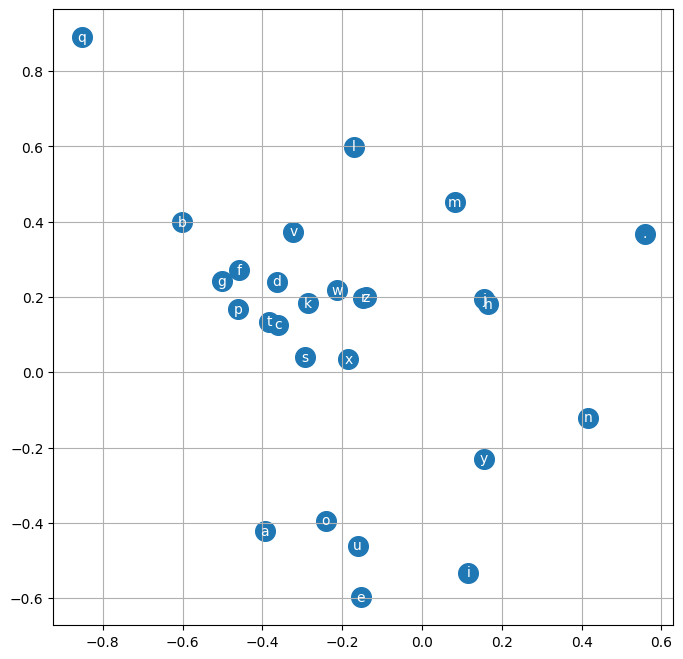

In [46]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

**TODO:** 9) Can you interpret the embedding plot? Do you see some structure that the network has learned, or is it purely random - especially compared to our initial plot above? **(2 points)**

**ANSWER:**  We can say that the network has learned some structures. In the first plot, all the dots were randomly distributed, but in this plot, some letters became closer because the network noticed that these letters came after each other more often.

## 10. Increasing the Embedding Dimension

**TODO:** 10a) Change the dimension of the embedding to 10 and re-run the training loop. **(2 points)** 

**HINT:** Note that the embedding dimension can be passed as input into `train_loop()`!

In [47]:
# YOUR CODE GOES HERE
embedding_dim = 10
context_length = 3
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, embedding_dim), generator=g)
W1 = torch.randn((embedding_dim * context_length, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True # we want to learn the parameters
    
parameters, stepi, lossi = trainloop(niter, Xtr, Ytr, parameters, lrs,emb_dim=10,output=False)


In [48]:
# evaluate losses on training and dev sets
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print('train loss:', loss)

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print('dev loss:', loss)

train loss: tensor(2.1819, grad_fn=<NllLossBackward0>)
dev loss: tensor(2.2276, grad_fn=<NllLossBackward0>)


Note that we are optimizing the model by hand here for educational purposes - in production, you would create hyperparameters and use grid search for a more systematic search.

**TODO:** 10b) How do you interpret train and dev losses now? **(1 point)**

**ANSWER:** The reduction in training loss means, that our model's capacity to learn more complex patterns has improved with the introduction of the hidden layer.

The reduction in development loss means, that the model's ability to generalize to unseen data has improved.

The relatively small gap between training loss and development loss indicates that the model is not overfitting.

## 11. Final Evaluation and Sampling from the Model

Once we have found a set of promising hyperparameters, we evaluate on the test set *once* and get the final loss to report in a paper for example. Then we can generate new samples using the model:

In [49]:
# sample from the model
g = torch.Generator().manual_seed(42 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ... as context
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # get next index by sampling
        context = context[1:] + [ix] # update context
        out.append(ix) # store the output
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

ellane.
yara.
elyn.
suberto.
blyn.
jehley.
daleigh.
koria.
ekna.
azeir.
keann.
leha.
evakon.
kagi.
ana.
avirackillineca.
jhevikchir.
jed.
jayeol.
nayah.
...truncated...

We see that the output looks a lot more like names now, we are making progress :-)

## 12. Challenge

**TODO (optional):** Try to beat the final validation loss above! Here are some suggestions to further improve the results:

- change the number of neurons in the hidden layer
- change the dimensionality of the embedding lookup table 
- change the number of characters that are feeding in as an input 
- change the details of the optimization: number of iterations, learning rate (decay)... 
- change the batch size 
- read the original paper (you should be able to understand large parts of it now and this paper also has a few ideas for improvements that you can play with)
- ...

Write in the answer cell below what you tried and whether it helped. What is your best validation loss?

**ANSWER:**

In [ ]:
block_size = 6
Xtr, Ytr = build_dataset(train_words)
Xdev, Ydev = build_dataset(dev_words)
Xte, Yte = build_dataset(test_words)


g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((27, 100), generator=g)
W1 = torch.randn((600, 60), generator=g)
b1 = torch.randn(60, generator=g)
W2 = torch.randn((60, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True # we want to learn the parameters
    
parameters, stepi, lossi = trainloop(niter, Xtr, Ytr, parameters, lrs,emb_dim=100,output=False,context_length=6)

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 600) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print('train loss:', loss)

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 600) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print('dev loss:', loss)


ayomide
...... ---> a
.....a ---> y
....ay ---> o
...ayo ---> m
..ayom ---> i
.ayomi ---> d
ayomid ---> e
yomide ---> .
odyssey
...... ---> o
.....o ---> d
....od ---> y
...ody ---> s
..odys ---> s
.odyss ---> e
odysse ---> y
dyssey ---> .
flavia
...... ---> f
...truncated...

(For this part we tried a couple of thing but we didnt continue to do it.)

In [53]:
# This cell truncates long output to a maximum length, then converts the notebook to a PDF
# NOTE: You may have to adapt the path or filename to match your local setup

import sys
import os

# Add the parent directory to the sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

# truncate long cell output to avoid large pdf files
from helpers.truncate_output import truncate_long_notebook_output
truncated = truncate_long_notebook_output('2_MLP_Language_Model__student.ipynb')

# convert to pdf with nbconvert
if truncated:
    !jupyter nbconvert --to webpdf --allow-chromium-download TRUNCATED_2_MLP_Language_Model__student.ipynb
else:
    !jupyter nbconvert --to webpdf --allow-chromium-download 2_MLP_Language_Model__student.ipynb

Output in 2_MLP_Language_Model__student.ipynb above threshold seen and so a NEW version has been made: `TRUNCATED_2_MLP_Language_Model__student.ipynb`.


[NbConvertApp] Converting notebook TRUNCATED_2_MLP_Language_Model__student.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 425548 bytes to TRUNCATED_2_MLP_Language_Model__student.pdf
